<h1 style="text-align: center;">MIS 542 &ndash; Advanced Business Analytics</h1>
<h1 style="text-align: center;">Course Project - Spam Detection</h1>

<h4> Team 7 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from dmba import classificationSummary
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rs7am\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rs7am\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rs7am\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data

In [2]:
mail_df = pd.read_csv('D:/MIS542/Project file.csv') 
mail_df = mail_df[['class', 'message']] #To have only wanted columns
mail_df.shape

(5572, 2)

# Preprocessing Data

valid    4825
spam      747
Name: class, dtype: int64


D:\rs7am\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='class'>

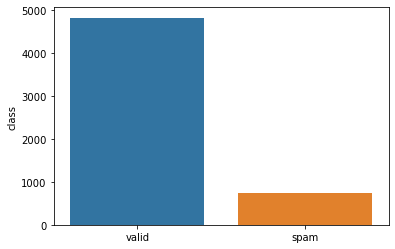

In [3]:
x=mail_df['class'].value_counts()
print(x)
sns.barplot(x.index,x)

#### Function for lowering case,  removing of special characters, stop words, hyperlinks, numbers, and white spaces

In [4]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text = text.strip() 
    text = re.compile('<.*?>').sub(' ', text)
    text = re.compile('http:\/\/.*[\r\n]*').sub(' ', text)
    text = re.compile('https:\/\/.*[\r\n]*').sub(' ', text) 
    text = re.compile('www.\/\/.*[\r\n]*').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'[^a-zA-Z0-9]',' ',text) 
    text = re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)  
    text = re.sub(r'\s+',' ',text)
    
    
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [5]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
mail_df['clean_message'] = mail_df['message'].apply(lambda x: finalpreprocess(x))

In [6]:
# all rows in the dataframe                                                                  
pd.set_option("display.max_rows", None, "display.max_colwidth", 199)
 
# printing data frame
mail_df.head()

,class,message,clean_message
0,valid,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",go jurong point crazy available bugis n great world la e buffet cine get amore wat
1,valid,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
3,valid,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,valid,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though


#### Text Transformation

In [7]:
# Apply CountVectorizer and TfidfTransformer sequentially
count_vect = CountVectorizer()
counts = count_vect.fit_transform(mail_df['clean_message'])
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [8]:
# Extract concepts using LSA ()

svd = TruncatedSVD()
normalizer = MinMaxScaler() # instead of Normalizer, we replaced it by MinMaxScaler to avoid negative values for NB model.
lsa = make_pipeline(svd, normalizer)
lsa_tfidf = lsa.fit_transform(tfidf)

# Analysis and Modeling

#### Data splitting and validation 

In [9]:
mail_df.loc[mail_df['class'] == 'Valid', 'class',] = 1
mail_df.loc[mail_df['class'] == 'spam', 'class',] = 0
y = (mail_df['class'] == 0).astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(lsa_tfidf, y, 
                                                      test_size=0.4, 
                                                      random_state=42)

### Oversampling spam class in the training set

In [10]:
#from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# instantiating the random over sampler 
ros = RandomOverSampler()

# resampling X_train, y_train
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# class distribution
print(Counter(y_train))
# new class distribution 
print(Counter(y_ros))

Counter({0: 2895, 1: 448})
Counter({0: 2895, 1: 2895})


## NB

#### Without Oversampling

In [11]:
# run naive Bayes
mail_nb = MultinomialNB(alpha=0.01)
mail_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = mail_nb.predict_proba(X_train)
predProb_valid = mail_nb.predict_proba(X_valid)

# predict class membership
y_train_pred = mail_nb.predict(X_train)
y_valid_pred = mail_nb.predict(X_valid)

# training
classificationSummary(y_train, y_train_pred)
# validation
classificationSummary(y_valid, y_valid_pred)

l = [0,0]
NB_table1 = pd.concat([pd.crosstab(y_valid, y_valid_pred), pd.DataFrame(l)], axis=1)

Confusion Matrix (Accuracy 0.8660)

       Prediction
Actual    0    1
     0 2895    0
     1  448    0
Confusion Matrix (Accuracy 0.8659)

       Prediction
Actual    0    1
     0 1930    0
     1  299    0


#### With Oversampling

In [12]:
# run naive Bayes
mail_nb1 = MultinomialNB(alpha=0.01)
mail_nb1.fit(X_ros, y_ros)

# predict probabilities
predProb_train = mail_nb1.predict_proba(X_ros)
predProb_valid = mail_nb1.predict_proba(X_valid)

# predict class membership
y_train_pred = mail_nb1.predict(X_ros)
y_valid_pred = mail_nb1.predict(X_valid)

# training
classificationSummary(y_ros, y_train_pred)
# validation
classificationSummary(y_valid, y_valid_pred)

NB_table2 = pd.crosstab(y_valid, y_valid_pred)

Confusion Matrix (Accuracy 0.7503)

       Prediction
Actual    0    1
     0 2408  487
     1  959 1936
Confusion Matrix (Accuracy 0.8201)

       Prediction
Actual    0    1
     0 1614  316
     1   85  214


## KNN

#### Without Oversampling

In [13]:
#Training the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#Predict testing set
y_pred = knn.predict(X_valid)

# training
classificationSummary(y_train, knn.predict(X_train))
# validation
classificationSummary(y_valid, y_pred)

KNN_table1 = pd.crosstab(y_valid, y_pred)

Confusion Matrix (Accuracy 0.9728)

       Prediction
Actual    0    1
     0 2868   27
     1   64  384
Confusion Matrix (Accuracy 0.9560)

       Prediction
Actual    0    1
     0 1888   42
     1   56  243


#### With Oversampling

In [14]:
#Training the model
knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(X_ros, y_ros)

#Predict testing set
y_pred = knn1.predict(X_valid)

# training
classificationSummary(y_ros, knn1.predict(X_ros))
# validation
classificationSummary(y_valid, y_pred)

KNN_table2 = pd.crosstab(y_valid, y_pred)

Confusion Matrix (Accuracy 0.9848)

       Prediction
Actual    0    1
     0 2807   88
     1    0 2895
Confusion Matrix (Accuracy 0.9305)

       Prediction
Actual    0    1
     0 1822  108
     1   47  252


#### Model Evaluation

In [15]:
def model_eval(matrix, model_name):
    tn = matrix.iloc[0,0] 
    tp = matrix.iloc[1,1] 
    fn = matrix.iloc[1,0] 
    fp = matrix.iloc[0,1] 
    tap = fn+tp
    tan = tn+fp
    tpn = tn+fn
    tpp = fp+tp
    precision = tp / tpp
    recall = tp / tap
    total = tn+tp+fn+fp
    
    
    data = [
        round((tp+tn)/(total),4),
        round(1-((tp+tn)/(total)),4),
        round(tp /(tap),4),
        round(tn /(tan),4),
        round(precision,4),
                                    ]
    
    return(pd.DataFrame(data, columns=[model_name], 
                        index = ['Accuracy','Error Rate','Sensitivity','Specificity','Precision']))



In [16]:
Model_NB = model_eval(NB_table1, model_name = 'NB') # Naive Bays, without oversampling
Model_NB1 = model_eval(NB_table2, model_name = 'NB w OS') # Naive Bays, with oversampling
Model_KNN = model_eval(KNN_table1, model_name = 'KNN') # K-Nearest Neighbor, without oversampling
Model_KNN1 = model_eval(KNN_table2, model_name = 'KNN w OS') # K-Nearest Neighbor, with oversampling

pd.concat([Model_NB, Model_NB1, Model_KNN, Model_KNN1], axis=1)

<ipython-input-15-f5c1f2b71443>:10: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / tpp


,NB,NB w OS,KNN,KNN w OS
Accuracy,0.8659,0.8201,0.9560,0.9305
Error Rate,0.1341,0.1799,0.0440,0.0695
Sensitivity,0.0000,0.7157,0.8127,0.8428
Specificity,1.0000,0.8363,0.9782,0.9440
Precision,NaN,0.4038,0.8526,0.7000


#### Demonstration

In [17]:
input_mail=  pd.read_excel('Input Mail.xlsx')
input_mail['clean_mail'] = input_mail['Input Mail'].apply(lambda x: finalpreprocess(x))

X_test=input_mail['clean_mail']
count1 = count_vect.transform(X_test)
X_vector1 = tfidfTransformer.transform(count1)
lsa_tfidf1 = lsa.transform(X_vector1)


prediction = knn1.predict(lsa_tfidf1)
print(prediction)
    
for i in range(0, input_mail.shape[0]): 
    if (prediction[i]==1):
         print('Spam mail', '\nmail:', input_mail['Input Mail'][i], '\n')
    else:
         print('Valid mail', '\nmail:', input_mail['Input Mail'][i], '\n')

[0 0 1 1]
Valid mail 
mail: I don't think I can get away for a trek that long with family in town, sorry 

Valid mail 
mail: Congratulations 𝗬𝗼𝘂𝗿 $25,000.00 𝗦𝗲𝘁𝘁𝗹𝗲𝗺𝗲𝗻𝘁 𝗖𝗵𝗲𝗰𝗸 𝗔𝗿𝗿𝗶𝘃𝗲𝗱 👉🏻 , 𝗟𝗮𝘀𝘁 𝗱𝗮𝘆 𝘁𝗼 𝗖𝗼𝗻𝗳𝗶𝗿𝗺 ✔Wed, 27 Apr 2022 17:44:45 -0400__ZWs1O 

Spam mail 
mail: Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16  

Spam mail 
mail: URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18 



<h3 style="text-align: center;">***************************** </h3>